# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement of SGHMC with Friction

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

In [264]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
from ipyparallel import Client
import random
import numpy

## Basic Code

In [265]:
def SGHMC_friction(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction. See details from Stochastic Gradient Hamiltonian Monte Carlo (Chen et al., 2014)
    
    INPUT:
    ----------------------------------------------------------------------
    theta0(numpy array of shape(p,)): starting position of theta
    
    X(numpy array of shape(n,m)): data
    
    gradU(scale,theta,batch): function to compute gradient of U on a particular batch,
    
        INPUT:
        ----------------------------------------------------------------------
        scale: data size/ batch size
        theta: theta
        batch(numpy array): batch
        ----------------------------------------------------------------------
        OUTPUT:
        ----------------------------------------------------------------------
        thetat: Gradient of U on batch
        ----------------------------------------------------------------------
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    ----------------------------------------------------------------------
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    
    i = sample_size+burnin
    p = theta0.shape[0]
    thetat = np.zeros((i+1,p))
    thetat[0,:] = theta0
    
    m1 = int(np.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    
    for t in range(i):
        ri = np.random.multivariate_normal(np.zeros(p), M)
        thetai = thetat[t]
        for j in range(m):
            thetai = thetai + eps * np.linalg.solve(M, ri)
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU - eps * C @ np.linalg.solve(M, ri) + np.random.multivariate_normal(np.zeros(p), np.array(2*eps*(C-B)).reshape(p,p))
        thetat[t+1] = thetai

    return thetat[burnin+1:]

## Example 1 (Test code and reproduce figure 1)

In [266]:
def gradU(scale,theta,batch):
    """
    Compute gradient of U on a particular batch
    
    INPUT:
    ----------------------------------------------------------------------
    scale:
    
    theta:
    
    batch: 
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: Gradient of U on batch
    """
    def grad_log_data(x,theta):
        return -(-4*theta+4*theta**3)/50

    def grad_log_prior(theta):
        return 0
    return - scale*batch.shape[0]*grad_log_data(batch,theta)-grad_log_prior(theta)

In [267]:
%%time
random.seed(100)
theta1 = SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU,
                eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 12.2 s, sys: 99.5 ms, total: 12.3 s
Wall time: 12.3 s


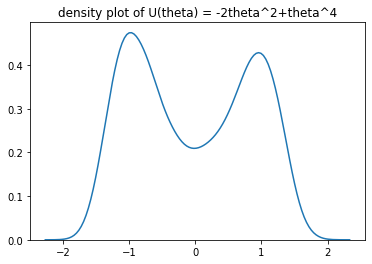

In [268]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))
plt.title('density plot of U(theta) = -2theta^2+theta^4')
plt.savefig('U_in_paper.png')

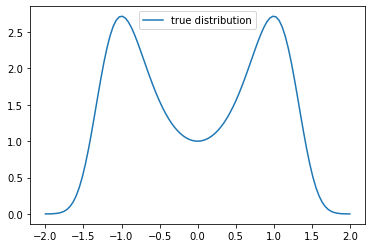

In [269]:
# real distribution of U_in_paper
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")
plt.savefig('real_U_in_paper.png')

## Example 2 (mixture normal)

In [270]:
mu = np.array([-5, 5]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [271]:
def gradU2(scale,theta,batch):
    def mn_glpdf(y,mu):
        exp1=numpy.exp(-0.5*(y-mu[0])**2)
        exp2=numpy.exp(-0.5*(y-mu[1])**2)

        v = numpy.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
        return numpy.sum(v/(exp1+exp2),axis=0)

    def mn_glpr(mu):
        return -(numpy.sum(mu)/100)
    return - scale*mn_glpdf(batch,theta)-mn_glpr(theta)

In [272]:
theta_mn = SGHMC_friction(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

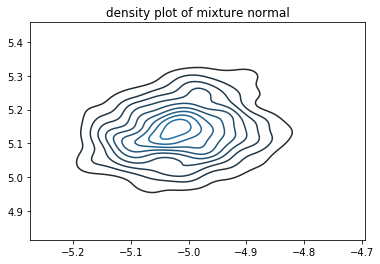

In [273]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.title('density plot of mixture normal')
plt.savefig('mixture_norm.png')

## example 3 (simulated linear model)

In [274]:
# simulated results for linear model, n = #{obs} = 100, p = 4 (p*p X matrix), s2 = 1, coef = [1,2,3,4]^T
n, p = 100, 3
s2 = 1
X = np.c_[np.random.normal(size=n), np.random.normal(size=n), np.random.normal(size=n)]
noise = np.random.normal(size=n).reshape(-1,1)
beta = np.array([2,3,4]).reshape(-1,1)
alpha = 1

Y = X @ beta + alpha + noise
data = np.c_[Y,X]

In [275]:
def logposterior(parameter, data, alpha_prior_m=0, alpha_prior_sd=10, beta_prior_m=1, beta_prior_sd=10, logs2_prior_m=0, logs2_prior_sd=10):
    '''
    
    Compute the log density of data and gradient of log density of data
    Parameter: beta and log variance (p+1,1)
    X: data matrix (n,p)
    Y: response (n,1)
    ..._prior_m = prior mean of elts in parameters
    ..._prior_sd = prior standard error of elts in parameters
    
    '''
    
    def normal_prior(p, mu, s):
        '''compute the log prior and gradient of log prior'''
        Z = (p-mu)/s
        logpdf = np.sum(-np.log(s) - 0.5*np.log(2*np.pi)-0.5*Z**2, axis=0)
        grad_logpdf = -Z/s
        
        return logpdf.reshape(-1,1), grad_logpdf.reshape(-1,1)
    
    Y = data[:,0].reshape(-1,1)
    X = data[:,1:]
    
    alpha = parameter[0]
    beta = parameter[1:parameter.shape[0]-1]
    beta = beta.reshape(-1,1)
    logs2 = parameter[parameter.shape[0]-1]
    
    # compute log likelihood and gradient
    sigma = np.sqrt(np.exp(logs2))
    mu = X @ beta + alpha
    Z = (Y-mu)/sigma
    
    grad_alpha1 = np.sum(Z/sigma)
    grad_beta1 = X.T @ Z/sigma
    grad_logs21 = np.sum(-0.5 + 0.5*Z**2)
    
    # compute log priors and gradient
    log_prior_alpha, grad_lp_alpha = normal_prior(alpha, alpha_prior_m, alpha_prior_sd)
    log_prior_beta, grad_lp_beta = normal_prior(beta, beta_prior_m, beta_prior_sd)
    log_prior_logs2, grad_lp_logs2 = normal_prior(logs2, logs2_prior_m, logs2_prior_sd)
    log_prior = log_prior_alpha + log_prior_beta + log_prior_logs2 # '+' in matlab
    
    # log posterior and gradient
    grad_alpha = grad_alpha1 + grad_lp_alpha
    grad_beta = grad_beta1 + grad_lp_beta
    grad_logs2 = grad_logs21 + grad_lp_logs2
    grad_log_post = np.hstack((grad_alpha[0], grad_beta[:,0], grad_logs2[0]))
    
    return grad_log_post

In [276]:
def gradU3(scale,theta,batch):
    '''compute gradient of U for linear model'''
    
    return - scale*logposterior(theta, batch)

In [277]:
theta_mn = SGHMC_friction(theta0=np.ones(5), X = data, gradU = gradU3, eps=0.01, sample_size=2000, B=0.01, C=np.eye(5), batch_size=20,burnin=500)

In [278]:
para_est = np.mean(theta_mn,axis = 0)
para_est

array([ 0.9280783 ,  2.21660783,  3.08414426,  4.00209875, -0.02937276])

In [279]:
para_est[1:4]

array([2.21660783, 3.08414426, 4.00209875])

In [280]:
# compute estimate
Y_est = para_est[0] + X @ para_est[1:4].reshape(-1,1)

In [281]:
rmse = np.sqrt(np.sum((Y-Y_est)**2))
rmse

9.973323065504621

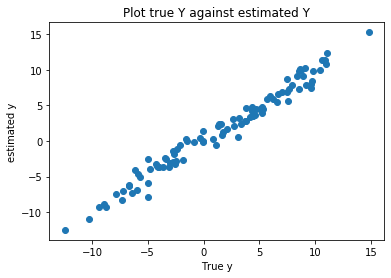

In [282]:
plt.scatter(Y,Y_est)
plt.xlabel('True y')
plt.ylabel('estimated y')
plt.title('Plot true Y against estimated Y')
plt.savefig('sim_lm_error.png')

## Example with real data 

In [324]:
import pandas as pd

In [325]:
dieb = pd.read_fwf('diab.txt')
dieb.head()

,npreg,glu,bp skin,bmi,ped age,diabetes,Unnamed: 6
0,5,86,68,28,30.2,0.364 24,No
1,7,195,70,33,25.1,0.163 55,Yes
2,5,77,82,41,35.8,0.156 35,No
3,0,165,76,43,47.9,0.259 26,No
4,0,107,60,25,26.4,0.133 23,No


In [326]:
dieb = dieb.drop("Unnamed: 6", axis=1)
dieb = dieb.drop("diabetes", axis=1)
dieb.head()

,npreg,glu,bp skin,bmi,ped age
0,5,86,68,28,30.2
1,7,195,70,33,25.1
2,5,77,82,41,35.8
3,0,165,76,43,47.9
4,0,107,60,25,26.4


In [327]:
# regress glu over other paramters
dieb = dieb[['glu','npreg','bp skin','bmi','ped age']]
dieb.head()

,glu,npreg,bp skin,bmi,ped age
0,86,5,68,28,30.2
1,195,7,70,33,25.1
2,77,5,82,41,35.8
3,165,0,76,43,47.9
4,107,0,60,25,26.4


In [328]:
data = dieb.to_numpy()
X = data[:,1:]
glu = data[:,0]
data.shape, X.shape, glu.shape

((532, 5), (532, 4), (532,))

In [329]:
# 1 intercept, 4 coef, 1 sigma2
random.seed(1)
theta_mn = SGHMC_friction(theta0=np.ones(6), X = data, gradU = gradU3, eps=0.01, sample_size=2000, B=0.01, C=np.eye(6), batch_size=20,burnin=500)

In [330]:
post_coef_m = np.mean(theta_mn, axis=0)
est_coef = post_coef_m[:post_coef_m.shape[0]-1]
est_coef

array([2.98499373, 0.96651555, 0.84848091, 0.15274972, 1.46899123])

In [333]:
post_coef_m

array([2.98499373, 0.96651555, 0.84848091, 0.15274972, 1.46899123,
       6.89886507])

In [331]:
est_glu = est_coef[0] + X @ est_coef[1:]

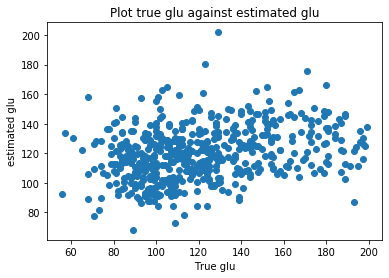

In [332]:
plt.scatter(glu,est_glu)
plt.xlabel('True glu')
plt.ylabel('estimated glu')
plt.title('Plot true glu against estimated glu')
plt.savefig('glu_estimation.png')

# data 2

In [340]:
df = pd.read_csv('salary.csv')

In [341]:
d = df.to_numpy()
scal = 10000
Y = d[:,1]/scal
X = d[:,0]

data = np.c_[Y,X]
Y.shape

(30,)

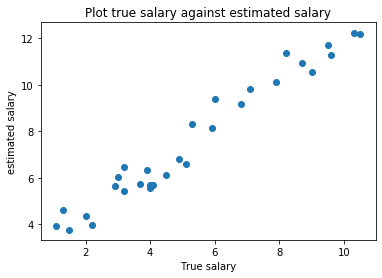

In [342]:
plt.scatter(X,Y)
plt.xlabel('True salary')
plt.ylabel('estimated salary')
plt.title('Plot true salary against estimated salary')
plt.savefig('salary_estimation.png')

In [348]:
# 1 intercept, 1 coef, 1 sigma2
theta_mn = SGHMC_friction(theta0=np.ones(3), X = data, gradU = gradU3, eps=0.01, sample_size=1000, B=0, C=np.eye(3), batch_size=20,burnin=500)

In [349]:
pm_coef=np.mean(theta_mn,axis=0)
pm_coef

array([ 1.87751572,  1.04037427, -0.56902881])

In [303]:
a = pm_coef[0]
b = pm_coef[1]

In [304]:
Y_est = a + b * X

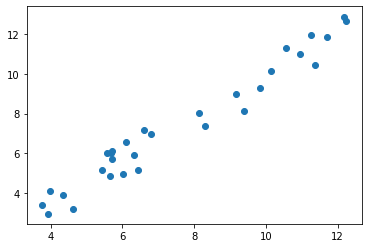

In [305]:
plt.scatter(Y,Y_est)

## Profile Basic SGHMC function

In [306]:
profile = %prun -r -q SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

          2132514 function calls (2057514 primitive calls) in 3.699 seconds

   Ordered by: cumulative time
   List reduced from 73 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.699    3.699 {built-in method builtins.exec}
        1    0.000    0.000    3.699    3.699 <string>:1(<module>)
        1    0.350    0.350    3.699    3.699 <ipython-input-265-0d59906a8798>:1(SGHMC_friction)
    15000    0.493    0.000    2.457    0.000 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
145000/70000    0.168    0.000    1.803    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15000    0.017    0.000    1.167    0.000 <__array_function__ internals>:2(allclose)
    15000    0.032    0.000    1.134    0.000 numeric.py:2103(allclose)
    15000    0.015    0.000    0.957    0.000 <__array_function__ internals>:2(isclose)
    15000    0.108    0.000    

## Use SqrtM @ Normal to replace multivariate normal

In [307]:
def SGHMC_friction2(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    sample_size: number of samples drawn from prosterior distribution
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    i = sample_size+burnin
    p = theta0.shape[0]
    thetat = np.zeros((i+1,p))
    thetat[0] = theta0
    
    m1 = int(np.ceil(X.shape[0]/batch_size))
    batch = [X[i::m1] for i in range(m1)]
    m = len(batch)

    if(M is None):
        M = np.eye(p)
    
    M1sqrt = np.linalg.cholesky(M)
    Msqrt = np.linalg.cholesky(2*eps*(C-B))
    
    for t in range(i):
        thetai = thetat[t]
        ri = M1sqrt@np.random.normal(size=p)
        for j in range(m):
            thetai = thetai + eps * np.linalg.solve(M,ri)
            gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
            ri = ri - eps * gU - eps * C @ np.linalg.solve(M, ri) + Msqrt@np.random.normal(size=p)
        thetat[t+1] = thetai
    
    return thetat[burnin+1:]

## Test SGHMC2

In [308]:
%%time
random.seed(100)
theta1 = SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU,
                eps=0.1,sample_size=10000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)

CPU times: user 2.89 s, sys: 32.8 ms, total: 2.92 s
Wall time: 2.9 s


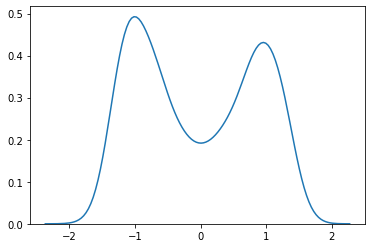

In [309]:
sns.kdeplot(theta1.reshape(-1,))
plt.show()

In [310]:
theta_mn = SGHMC_friction2(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=1000, B=0, C=np.eye(2), batch_size=100,burnin=500)

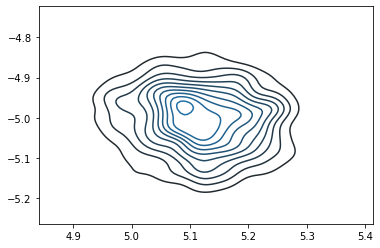

In [311]:
kdeplt2 = sns.kdeplot(theta_mn[:,0],theta_mn[:,1])  
plt.show()

## Profile SGHMC2

In [ ]:
profile = %prun -r -q SGHMC_friction2(theta0 = np.array([0]),X = np.zeros((50,1)), gradU = gradU, eps=0.1,sample_size=2000, B=np.array([0]),C=2*np.eye(1),batch_size = 10,burnin=500)
profile.sort_stats('cumtime').print_stats(10)

## Use parallel computation to test code

In [319]:
def parallel_setup(view):
    with view.sync_imports():
        import numpy

In [320]:
def SGHMC_parallel(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, n , M = None):
    '''
    parallel version of SGHMC. Please set ipython Clusters before running the following code.
    
    SETUP:
    ----------------------------------------------------------------------
    Step1:
    Open a terminal (cmd.exe) and type:
    ipcluster start -n 4(or other specified number of engines)
    
    Step2: 
    Run the following code 
    
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    with dv.sync_imports():
        import numpy
    
    dv.push(dict(gradU=gradU))
    
        
    INPUT:
    ----------------------------------------------------------------------
    theta0: starting position of theta
    
    X: data
    
    grad_logden_data: gradient of the data log density
    
    grad_logden_prior: gradient of the prior log density
    
    eps: step size
    
    sample_size: number of samples drawn from prosterior distribution
    
    B: noise estimate
    
    C: user specified friction term
    
    batch_size: size of minibatches
    
    burnin: number of iterations for warm up
    
    M(optional): Mass matrix, defualt is set to be identity.
    ----------------------------------------------------------------------
    OUTPUT:
    
    thetat: thetas sampled from posterior distribution
    ----------------------------------------------------------------------
    '''
    from ipyparallel import Client
    rc = Client()
    dv = rc[:]
    n = len(rc.ids)
    parallel_setup(dv)
    
    dv.push(dict(gradU=gradU))
    i = int((sample_size+n*burnin)/4)  

    @dv.remote(block=True)
    def SGHMC_friction4(theta0, X, gradU, eps, sample_size, B, C, batch_size,burnin, M = None):

        i = sample_size+burnin
        p = theta0.shape[0]
        thetat = numpy.zeros((i+1,p))
        thetat[0] = theta0

        m1 = int(numpy.ceil(X.shape[0]/batch_size))
        batch = [X[i::m1] for i in range(m1)]
        m = len(batch)

        if(M is None):
            M = numpy.eye(p)

        M1sqrt = numpy.linalg.cholesky(M)
        Msqrt = numpy.linalg.cholesky(2*eps*(C-B))

        for t in range(i):
            thetai = thetat[t]
            ri = M1sqrt@numpy.random.normal(size=p)
            for j in range(m):
                thetai = thetai + eps * numpy.linalg.solve(M,ri)
                gU = gradU(X.shape[0]/batch[j].shape[0],thetai,batch[j])
                ri = ri - eps * gU - eps * C @ numpy.linalg.solve(M, ri) + Msqrt@numpy.random.normal(size=p)
            thetat[t+1] = thetai

        return thetat[burnin+1:]
    
    theta = SGHMC_friction4(theta0, X, gradU, eps, i, B, C, batch_size,burnin, M)
    return numpy.concatenate(theta)

In [321]:
theta1 = SGHMC_parallel(np.array([0]),np.zeros((50,1)),gradU,0.1,10000, np.array([0]),2*np.eye(1),10,500,4)

importing numpy on engine(s)


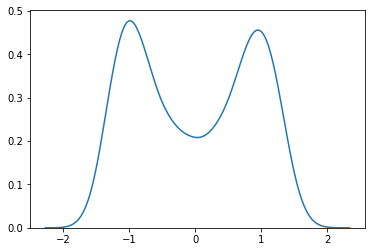

In [322]:
sns.kdeplot(np.concatenate(theta1).reshape(-1,))

In [323]:
theta_mn = SGHMC_parallel(theta0=np.array([1,1]), X = y[:,None], gradU = gradU2, eps=0.01, sample_size=5000, B=0, C=np.eye(2), batch_size=100,burnin=500)

TypeError: SGHMC_parallel() missing 1 required positional argument: 'n'